In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy.io import loadmat
%matplotlib inline

In [2]:
# OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=0.6
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

In [3]:
# filtering
fc=[10,7,4,2]
x_set=[L]
for ifc in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    x_set.append(Lf)

(150.0, 152.0)

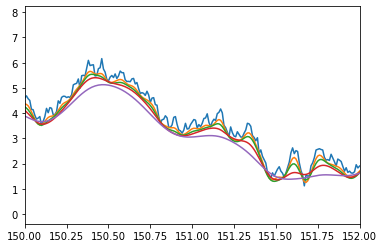

In [4]:
for i in range(np.size(x_set,0)):
    x_set[i]=x_set[i]-np.min(x_set[i])
    plt.plot(T,x_set[i])
plt.xlim(150,152)

(-14.989000000000003, 314.98900000000003)

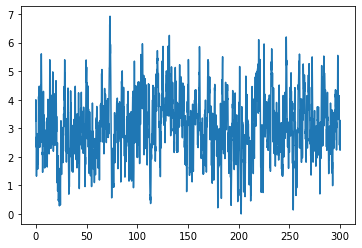

In [5]:
plt.plot(T,x_set[3])
plt.xlim()

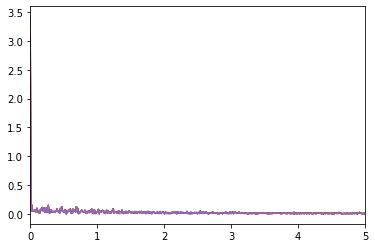

In [6]:
#FFT
for nset in range(np.size(x_set,0)):
    Ts=dt
    xft=fft(x_set[nset])
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    
    f = np.arange(len(xft))
    f2 = f[range(int(len(xft)/2))]
    f2=f2*Ts
    plt.plot(f2,xft_nor2)
    plt.xlim(0,5)

In [7]:
y_set=[]
z_set=[]
for i in range(np.size(x_set,0)):
    x=x_set[i]

    alpha = 20
    beta =  1
    K = 30
    g = 10
    
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    
    b, a = signal.butter(2, 2*0.2*dt, btype='low', analog=False)
    xadapt = signal.filtfilt(b, a, x)
    betac=0.5
    for j in range(len(T)-1):
        dy=dt*(-(1+betac*xadapt[j])*alpha*y[j]+K*(x[j]-(1+betac*xadapt[j])*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    y_set.append(y)
    z_set.append(z)

In [8]:
# same scale
for i in range(np.size(x_set,0)):
    x_set[i]=x_set[i]/np.std(x_set[i])
    y_set[i]=y_set[i]/np.std(y_set[i])
    z_set[i]=z_set[i]/np.std(z_set[i])

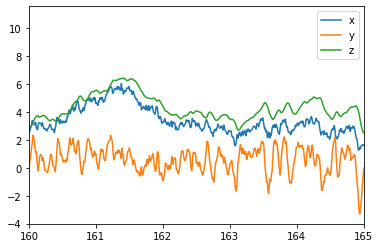

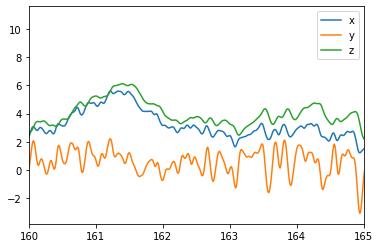

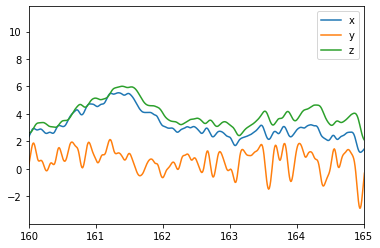

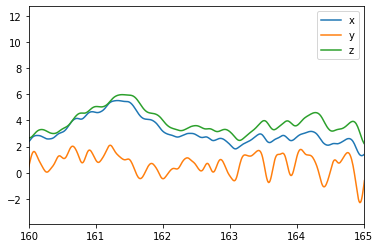

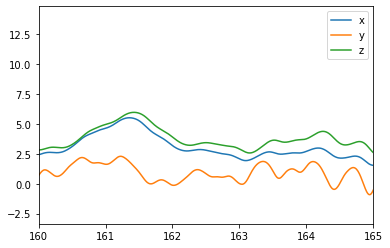

In [9]:
for i in range(np.size(x_set,0)):
    plt.plot(T,x_set[i])
    plt.plot(T,y_set[i])
    plt.plot(T,z_set[i])
    plt.xlim(160,165)
    plt.legend(('x','y','z'))
    plt.show()

In [10]:
# assign data to different state
# state number should be even
nx=8
ny=8

xstate_set=[]
ystate_set=[]
for nset in range(np.size(x_set,0)):
# states of input
    xs=x_set[nset]
    xs=np.sort(xs)
    xstatestep=len(xs)/nx
    xinterval=[0]
    for i in range(int(nx/2-1)):
        xinterval=np.append(xinterval,xs[round(len(xs)/2)+(i+1)*round(xstatestep)])
    xinterval=np.append(xinterval,float('inf'))
    for j in range(int(nx/2-1)):
        xinterval=np.append(xs[round(len(xs)/2)-(j+1)*round(xstatestep)],xinterval)
    xinterval=np.append(float('-inf'),xinterval)
    xstate=np.zeros(len(x_set[nset]))
    for i in range(len(x_set[nset])):
        tempinterval=[]
        state=[]
        tempinterval=np.array(xinterval)
        tempinterval=np.append(tempinterval,x_set[nset][i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==x_set[nset][i])
        xstate[i]=state[0][0]
    xstate = xstate.astype(int)

    # states of output
    ys=np.sort(y_set[nset])
    ystatestep=len(ys)/ny
    yinterval=[0]
    for i in range(int(ny/2-1)):
        yinterval=np.append(yinterval,ys[round(len(ys)/2)+(i+1)*round(ystatestep)])
    yinterval=np.append(yinterval,float('inf'))
    for j in range(int(ny/2-1)):
        yinterval=np.append(ys[round(len(ys)/2)-(j+1)*round(ystatestep)],yinterval)
    yinterval=np.append(float('-inf'),yinterval)
    ystate=np.zeros(len(y_set[nset]))
    for i in range(len(y_set[nset])):
        tempinterval=[]
        state=[]
        tempinterval=np.array(yinterval)
        tempinterval=np.append(tempinterval,y_set[nset][i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==y_set[nset][i])
        ystate[i]=state[0][0]
    ystate = ystate.astype(int)
    
    xstate_set.append(xstate)
    ystate_set.append(ystate)



In [11]:
r_set = y_set
rstate_set = []
for i in range(len(r_set)):
    edges = np.append(min(r_set[i]), np.array([np.std(r_set[i]),2*np.std(r_set[i]),3*np.std(r_set[i])])+np.mean(r_set[i]));
    rstate = np.zeros(len(r_set[i]))
    for j in range(4):
        rstate[r_set[i]>=edges[j]] = j
    rstate = rstate.astype(int)
    rstate_set.append(rstate)
ystate_set = rstate_set

In [12]:
# for i in range(np.size(x_set,0)):
#     plt.plot(T,xstate_set[i])
#     plt.plot(T,ystate_set[i])
#     plt.xlim(100,120)
#     plt.show()

In [13]:
# MI calculation
MI_set=[]
for k in range(np.size(x_set,0)):
    xstate=x_set[k]
    ystate=y_set[k]
    
    negshift=-1 # second
    posshift=1 # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=[]
    yedges=[]
    xs=np.sort(xstate)
    ys=np.sort(ystate)
    for ii in range(nx):
        ind=int((ii)*len(xstate)/nx)
        xedges.append(xs[ind])
        yedges.append(ys[ind])
    xedges.append(xs[-1])
    yedges.append(ys[-1])

    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])
        MI[i]=np.sum(MIsingle)
        
    MI_set.append(MI)
    

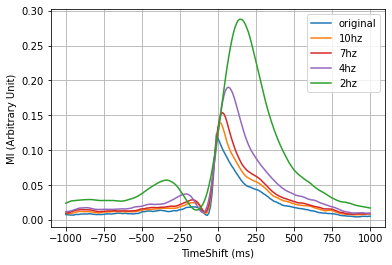

In [14]:
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift*1000,MI_set[i],color=colorlist[i]) 
    plt.xlim()
    plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
    plt.grid()
    plt.xlim()

In [15]:
# path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200408/MIdata/'
# file=['20200408_OU_original_tau=0p5_sort_unit2_MI.mat','20200408_OU_cutoff=10_sort_unit2_MI.mat',\
#       '20200408_OU_cutoff=7_sort_unit2_MI.mat','20200408_OU_cutoff=4_sort_unit2_MI.mat',\
#      '20200408_OU_cutoff=2_sort_unit2_MI.mat']

# path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
# file=['OU_tau=100ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
#       'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
#      'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat']

path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
file=['OU_tau=1000ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
      'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
     'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat']

MIlist=[[] for n in range(5)]
expdata=[0 for n in range(5)]
channel=38
for i in range(5):
    expdata=loadmat(path+file[i])
    MI=expdata['MI']
    TS=expdata['TimeShift']
    TS=TS[0]
    MIlist[i]=MI[0][channel][0]

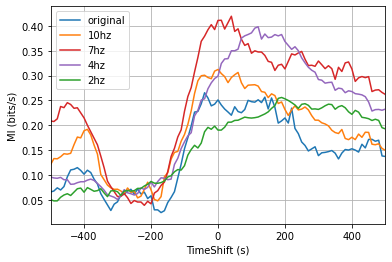

In [16]:
for i in range(5):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(TS,MIlist[i],color=colorlist[i])
    plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.xlabel('TimeShift (s)')
    plt.ylabel('MI (bits/s)')
    plt.xlim(-500,500)
    plt.grid()

In [17]:
# find MI peak positions
# simulation
TSpeak_exp=np.zeros(len(MI_set))
TSpeak_sim=np.zeros(len(MI_set))
for i in range(len(MI_set)):
    loc=np.argmax(MI_set[i])
    TSpeak_exp[i]=timeshift[loc]*1000
    loc2=np.argmax(MIlist[i])
    TSpeak_sim[i]=TS[loc2]

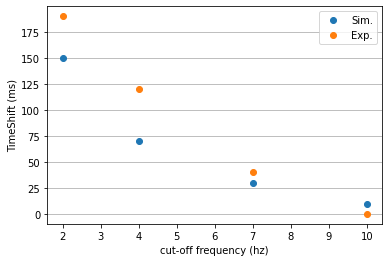

In [18]:
fc=np.array([float('inf'),10,7,4,2])
plt.plot(fc,TSpeak_exp,'o')
plt.plot(fc,TSpeak_sim,'o')
plt.grid(axis='y')
plt.ylabel('TimeShift (ms)')
plt.xlabel('cut-off frequency (hz)')
plt.legend(('Sim.','Exp.'))